In [1]:
import csv
import numpy as np
import sklearn as sk

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

import copy as cp
import pandas as pd
from progressbar import ProgressBar

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path
import re
import sys
import tarfile

from six.moves import urllib
import tensorflow as tf

from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform

We get some of the TensorFlow specific items out of the way first:

In [2]:
FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string(
    'model_dir', '/tmp/imagenet',
    """Path to classify_image_graph_def.pb, """
    """imagenet_synset_to_human_label_map.txt, and """
    """imagenet_2012_challenge_label_map_proto.pbtxt.""")
tf.app.flags.DEFINE_string('image_file', '',
                           """Absolute path to image file.""")
tf.app.flags.DEFINE_integer('num_top_predictions', 5,
                            """Display this many predictions.""")

# pylint: disable=line-too-long
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
# pylint: enable=line-too-long

class NodeLookup(object):
  """Converts integer node ID's to human readable labels."""

  def __init__(self,
               label_lookup_path=None,
               uid_lookup_path=None):
    if not label_lookup_path:
      label_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_2012_challenge_label_map_proto.pbtxt')
    if not uid_lookup_path:
      uid_lookup_path = os.path.join(
          FLAGS.model_dir, 'imagenet_synset_to_human_label_map.txt')
    self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

  def load(self, label_lookup_path, uid_lookup_path):
    """Loads a human readable English name for each softmax node.

    Args:
      label_lookup_path: string UID to integer node ID.
      uid_lookup_path: string UID to human-readable string.

    Returns:
      dict from integer node ID to human-readable string.
    """
    if not tf.gfile.Exists(uid_lookup_path):
      tf.logging.fatal('File does not exist %s', uid_lookup_path)
    if not tf.gfile.Exists(label_lookup_path):
      tf.logging.fatal('File does not exist %s', label_lookup_path)

    # Loads mapping from string UID to human-readable string
    proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
    uid_to_human = {}
    p = re.compile(r'[n\d]*[ \S,]*')
    for line in proto_as_ascii_lines:
      parsed_items = p.findall(line)
      uid = parsed_items[0]
      human_string = parsed_items[2]
      uid_to_human[uid] = human_string

    # Loads mapping from string UID to integer node ID.
    node_id_to_uid = {}
    proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
    for line in proto_as_ascii:
      if line.startswith('  target_class:'):
        target_class = int(line.split(': ')[1])
      if line.startswith('  target_class_string:'):
        target_class_string = line.split(': ')[1]
        node_id_to_uid[target_class] = target_class_string[1:-2]

    # Loads the final mapping of integer node ID to human-readable string
    node_id_to_name = {}
    for key, val in node_id_to_uid.items():
      if val not in uid_to_human:
        tf.logging.fatal('Failed to locate: %s', val)
      name = uid_to_human[val]
      node_id_to_name[key] = name

    return node_id_to_name

  def id_to_string(self, node_id):
    if node_id not in self.node_lookup:
      return ''
    return self.node_lookup[node_id]

def create_graph():
  """Creates a graph from saved GraphDef file and returns a saver."""
  # Creates graph from saved graph_def.pb.
  with tf.gfile.FastGFile(os.path.join(
      FLAGS.model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')


In [3]:
def maybe_download_and_extract():
    """Download and extract model tar file."""
    
    dest_directory = FLAGS.model_dir
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading %s %.1f%%' % (
                    filename, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        
        filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath,
                                                 reporthook=_progress)
        print()
        statinfo = os.stat(filepath)
        print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
    
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

maybe_download_and_extract()

Functions to generate results

In [4]:
def compute_all_distances(X, metric='euclidean'):
    """ Computes pairwise distances for points stored row-wise in X """
    return squareform(pdist(X, metric=metric))

def representation_metric_all_samples(dist, y):
    """ 
    Given a pairwise distance matrix dist and labels y, computes ratio of
    pairwise average intra-class distance to average inter-class distance
    """
    assert len(dist.shape) == 2 and dist.shape[0] == dist.shape[1], (
        'Distance matrix is not square!')
    
    within_group_distance = 0.
    between_group_distance = 0.
    num_within, num_between = 0, 0
    
    labels = np.unique(y)
    for label in labels:
        label_mask = y==label
        
        within_group_distance += dist[label_mask].T[label_mask].sum()
        between_group_distance += dist[label_mask].T[~label_mask].sum()
        
        num_within += label_mask.sum() * (label_mask.sum()-1) / 2
        num_between += label_mask.sum() * (~label_mask).sum()
    
    return (between_group_distance / within_group_distance 
            * num_within / num_between 
            * 2)

In [5]:
def permute_labels(y):
    """ Permutes the numpy array y """
    ls = cp.copy(y)
    np.random.shuffle(ls)
    return ls

In [6]:
def compute_clustering_stats(data, labels, num_iter):
    """ Computes clustering goodness and significance using permutation testing """
    
    dist = compute_all_distances(data)
    metric_for_permuted = (
        [representation_metric_all_samples(dist, labels if i==0 else permute_labels(labels)) 
         for i in range(num_iter)])
    
    p = float((metric_for_permuted >= metric_for_permuted[0]).sum()) / num_iter
    
    stats = {
        'true': metric_for_permuted[0],
        'metric': metric_for_permuted[1:],
        'p': p # p_value
    }
    return stats

In [7]:
def import_labels(labels_file_path):
    with open(labels_file_path,'rU') as f:
        return  np.asanyarray(pd.read_csv(f).Class).astype(int)

In [8]:
# function to create list of images
def dataset_gen(samplesPath, data_dir):
    with open(samplesPath, 'rU') as f:
        return [getImage(data_dir, im) for im in pd.read_csv(f).Id]
    
def getImage(data_dir, im):
    jpg_filepath = os.path.join(data_dir, '%s.jpg' % im) 
    png_filepath = os.path.join(data_dir, '%s.png' % im)
    if os.path.exists(jpg_filepath):
        return open(jpg_filepath, 'rb').read()
    elif os.path.exists(png_filepath):
        return open(png_filepath, 'rb').read()
    else:
        raise IOError('No file %s.{jpg, png} found in %s' % (im, data_dir))
    

In [9]:
# function to generate features
def generateFeatures(layer_name, dataset):
    """Generate and save features as csv for a particular layer and dataset.
    Keyword arguments:
    layer_name -- String: the name of the tensor, ex 'pool_3:0'
    dataset -- Generator: an iterator over the image dataset
    """ 
    create_graph()
    all_features = []
    with tf.Session() as sess:
        layer = sess.graph.get_tensor_by_name(layer_name)
        for image_data in dataset:
            features = sess.run(layer, {'DecodeJpeg/contents:0': image_data})
            features = np.reshape(features, (np.product(features.shape)))
            all_features.append(features)
    return np.asanyarray(all_features).astype(float)


In [10]:
tsne_model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

def plot_TSNE(data, labels):
    points = tsne_model.fit_transform(data)
    df = pd.DataFrame(data=np.column_stack([points,labels]), columns=["x","y","class"])
    sns.lmplot("x", "y", data=df, hue='class', fit_reg=False,
                     palette=sns.color_palette('colorblind'))
    sns.plt.show()

In [11]:
def plotStats(layer_stats):
    layer_names = sorted(layer_stats.keys())
    permutation_dist = pd.DataFrame(data=np.column_stack([layer_stats[layer]["metric"] 
                                                          for layer in layer_names]),
                                    columns=layer_names)
    true_values = pd.DataFrame(data=np.column_stack([layer_stats[layer]["true"] 
                                                     for layer in layer_names]),
                               columns=layer_names)
    
    sns.violinplot(data=permutation_dist, inner=None, order=layer_names, 
                   palette=sns.color_palette('colorblind'))
    sns.pointplot(data=true_values, join=False, color="#bb3f3f", order=layer_names)
    
    sns.plt.show()
    

In [12]:
def run(layers, datasets):
    for dataset_name in datasets:
        print('Processing %s' % dataset_name)
        layer_results = {}
        
        dataset = datasets[dataset_name]['data']
        classes = datasets[dataset_name]['labels']
        should_plot = datasets[dataset_name]['plotTSNE']
        
        for layer_name in layers:
            print("Generating features for dataset '%s', layer '%s'" % (dataset_name, layer_name))
            features = generateFeatures(layers[layer_name], dataset)
            
            # t-SNE is computationally expensive
            # For large number of observations we optionally skip this step
            if should_plot:
                print("t-SNE for dataset '%s', layer '%s'" % (dataset_name, layer_name))
                plot_TSNE(features, classes)
            
            print("Generating stats for dataset '%s', layer '%s'" % (dataset_name, layer_name))
            stats = compute_clustering_stats(features, classes, 1000)
            layer_results[layer_name] = stats
            
            print("p-value for dataset '%s', layer '%s': %f" % (dataset_name, layer_name, stats['p']))
            print('='*20)
            
        # plot the stats for the dataset, each layer will have a boxplot for the metric 
        # with permuted labels and true value
        print("Stats for dataset '%s'" % dataset_name)
        plotStats(layer_results)
        
        print('\n')
        print('*' * 20)
        print('*' * 20)
        print('\n')
        

# Synthetic, Images, and Emotion datasets
Input Data and Run Model

In [13]:
layers = {'layer_1': 'pool:0', 
          'layer_2': 'mixed_3/pool:0', 
          'layer_3': 'mixed_8/pool:0', 
          'layer_4': 'pool_3:0'}

datasets = {'Synthetic' : {
                'data': dataset_gen("datasets/synthetic/trainLabels.csv", "datasets/synthetic"),
                'labels': import_labels("datasets/synthetic/trainLabels.csv"),
                'plotTSNE': True
                },
            'Images': {
                'data': dataset_gen("datasets/images/trainLabels.csv", "datasets/images"),
                'labels': import_labels("datasets/images/trainLabels.csv"),
                'plotTSNE': True
                },
            'Emotion': {
                'data': dataset_gen("datasets/emotion/samples.csv", "datasets/emotion"),
                'labels': import_labels("datasets/emotion/samples.csv"),
                'plotTSNE': True
                }
           }

Processing Synthetic
Generating features for dataset 'Synthetic', layer 'layer_1'
t-SNE for dataset 'Synthetic', layer 'layer_1'


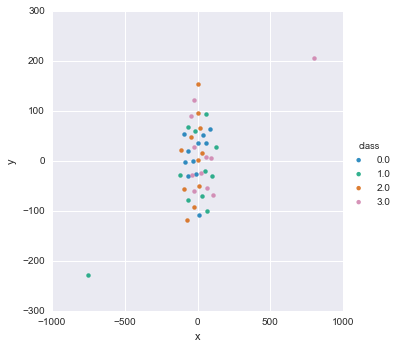

Generating stats for dataset 'Synthetic', layer 'layer_1'
p-value for dataset 'Synthetic', layer 'layer_1': 0.273000
Generating features for dataset 'Synthetic', layer 'layer_3'
t-SNE for dataset 'Synthetic', layer 'layer_3'


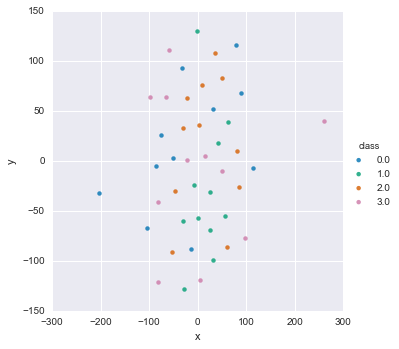

Generating stats for dataset 'Synthetic', layer 'layer_3'
p-value for dataset 'Synthetic', layer 'layer_3': 0.001000
Generating features for dataset 'Synthetic', layer 'layer_2'
t-SNE for dataset 'Synthetic', layer 'layer_2'


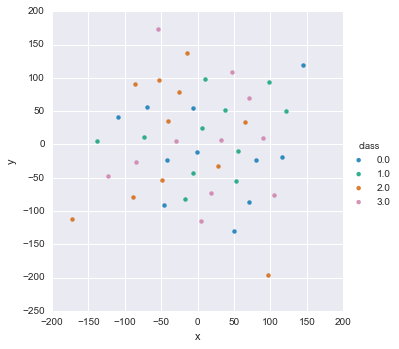

Generating stats for dataset 'Synthetic', layer 'layer_2'
p-value for dataset 'Synthetic', layer 'layer_2': 0.018000
Generating features for dataset 'Synthetic', layer 'layer_4'
t-SNE for dataset 'Synthetic', layer 'layer_4'


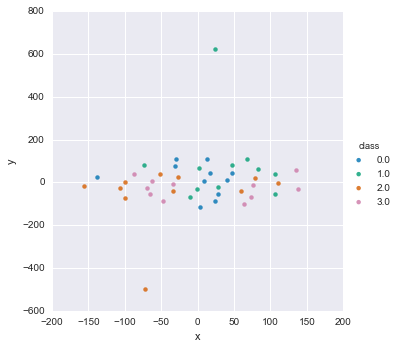

Generating stats for dataset 'Synthetic', layer 'layer_4'
p-value for dataset 'Synthetic', layer 'layer_4': 0.001000
Stats for dataset 'Synthetic'


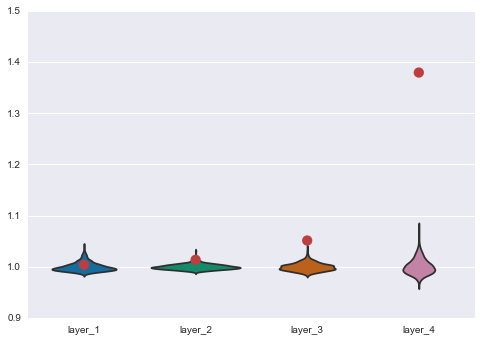



********************
********************


Processing Images
Generating features for dataset 'Images', layer 'layer_1'
t-SNE for dataset 'Images', layer 'layer_1'


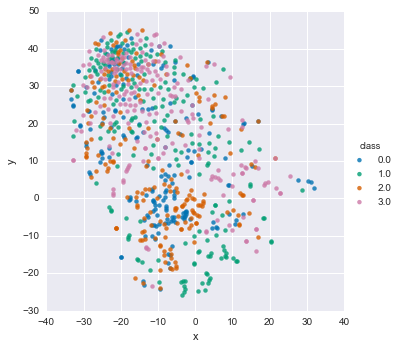

Generating stats for dataset 'Images', layer 'layer_1'
p-value for dataset 'Images', layer 'layer_1': 0.001000
Generating features for dataset 'Images', layer 'layer_3'
t-SNE for dataset 'Images', layer 'layer_3'


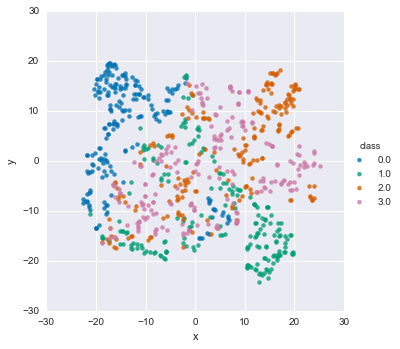

Generating stats for dataset 'Images', layer 'layer_3'
p-value for dataset 'Images', layer 'layer_3': 0.001000
Generating features for dataset 'Images', layer 'layer_2'
t-SNE for dataset 'Images', layer 'layer_2'


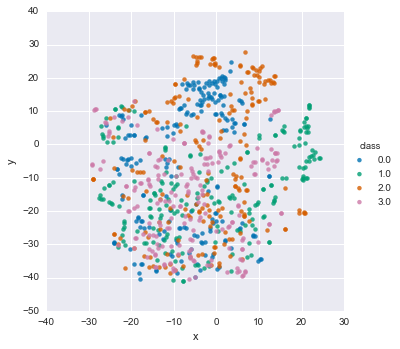

Generating stats for dataset 'Images', layer 'layer_2'
p-value for dataset 'Images', layer 'layer_2': 0.001000
Generating features for dataset 'Images', layer 'layer_4'
t-SNE for dataset 'Images', layer 'layer_4'


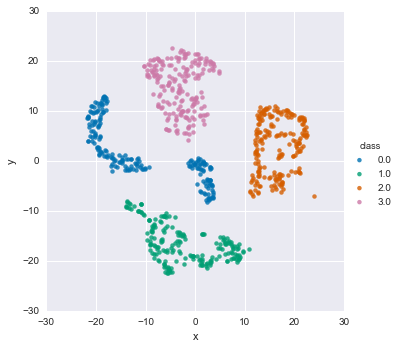

Generating stats for dataset 'Images', layer 'layer_4'
p-value for dataset 'Images', layer 'layer_4': 0.001000
Stats for dataset 'Images'


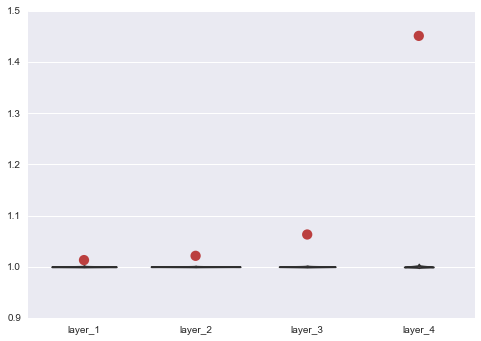



********************
********************


Processing Emotion
Generating features for dataset 'Emotion', layer 'layer_1'
t-SNE for dataset 'Emotion', layer 'layer_1'


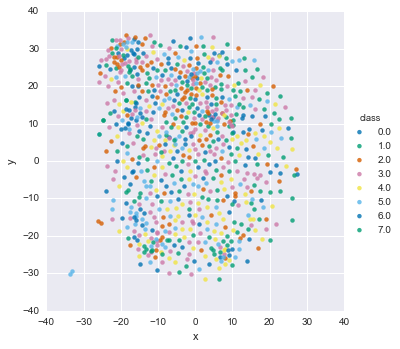

Generating stats for dataset 'Emotion', layer 'layer_1'
p-value for dataset 'Emotion', layer 'layer_1': 0.001000
Generating features for dataset 'Emotion', layer 'layer_3'
t-SNE for dataset 'Emotion', layer 'layer_3'


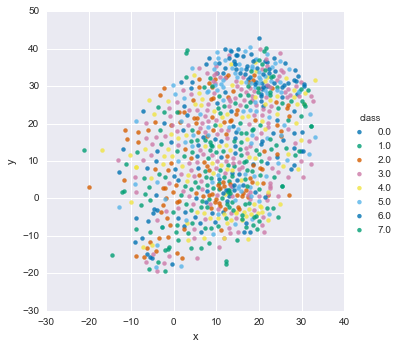

Generating stats for dataset 'Emotion', layer 'layer_3'
p-value for dataset 'Emotion', layer 'layer_3': 0.001000
Generating features for dataset 'Emotion', layer 'layer_2'
t-SNE for dataset 'Emotion', layer 'layer_2'


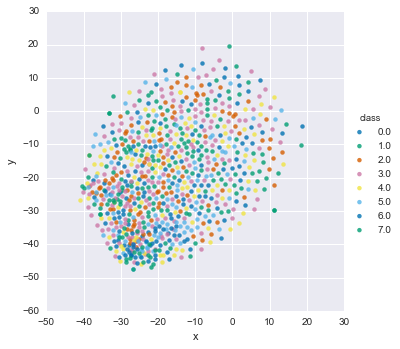

Generating stats for dataset 'Emotion', layer 'layer_2'
p-value for dataset 'Emotion', layer 'layer_2': 0.001000
Generating features for dataset 'Emotion', layer 'layer_4'
t-SNE for dataset 'Emotion', layer 'layer_4'


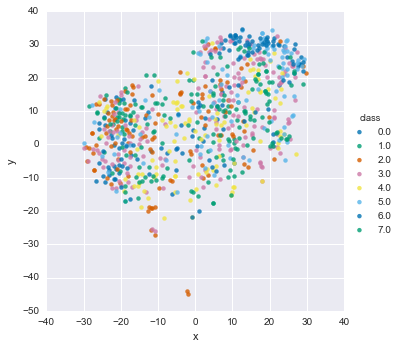

Generating stats for dataset 'Emotion', layer 'layer_4'
p-value for dataset 'Emotion', layer 'layer_4': 0.001000
Stats for dataset 'Emotion'


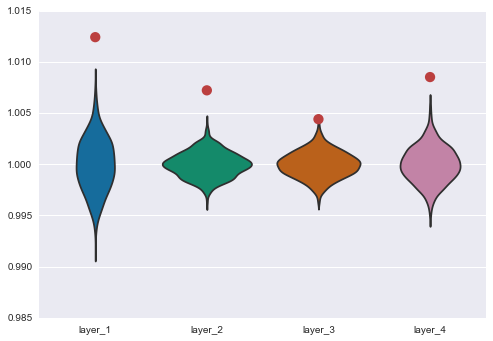



********************
********************




In [14]:
run(layers, datasets)

# Texture dataset

Processing Texture
Generating features for dataset 'Texture', layer 'layer_1'
t-SNE for dataset 'Texture', layer 'layer_1'


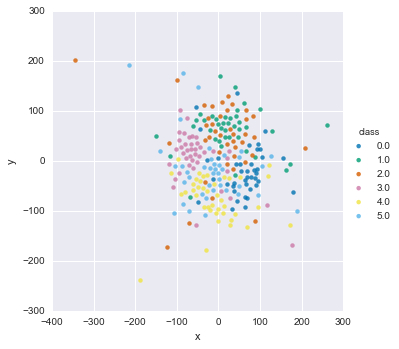

Generating stats for dataset 'Texture', layer 'layer_1'
p-value for dataset 'Texture', layer 'layer_1': 0.001000
Generating features for dataset 'Texture', layer 'layer_3'
t-SNE for dataset 'Texture', layer 'layer_3'


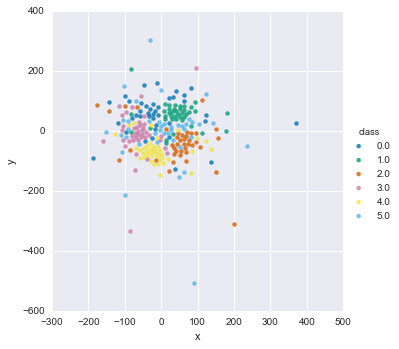

Generating stats for dataset 'Texture', layer 'layer_3'
p-value for dataset 'Texture', layer 'layer_3': 0.001000
Generating features for dataset 'Texture', layer 'layer_2'
t-SNE for dataset 'Texture', layer 'layer_2'


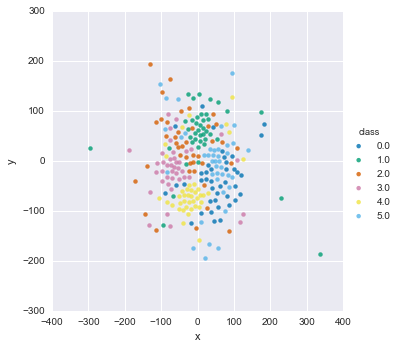

Generating stats for dataset 'Texture', layer 'layer_2'
p-value for dataset 'Texture', layer 'layer_2': 0.001000
Generating features for dataset 'Texture', layer 'layer_4'
t-SNE for dataset 'Texture', layer 'layer_4'


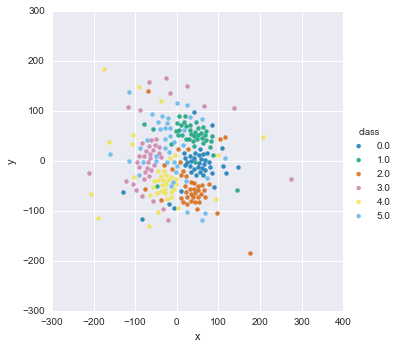

Generating stats for dataset 'Texture', layer 'layer_4'
p-value for dataset 'Texture', layer 'layer_4': 0.001000
Stats for dataset 'Texture'


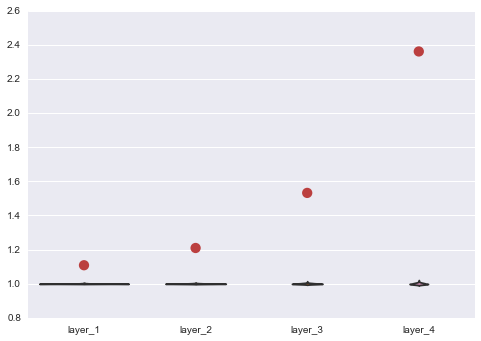



********************
********************




In [15]:
datasets = {'Texture' : {
                'data': dataset_gen("datasets/texture/samples.csv", "datasets/texture"),
                'labels': import_labels("datasets/texture/samples.csv"),
                'plotTSNE': True
                }
           }
run(layers, datasets)

# MNIST dataset

Processing Texture
Generating features for dataset 'Texture', layer 'layer_1'
t-SNE for dataset 'Texture', layer 'layer_1'


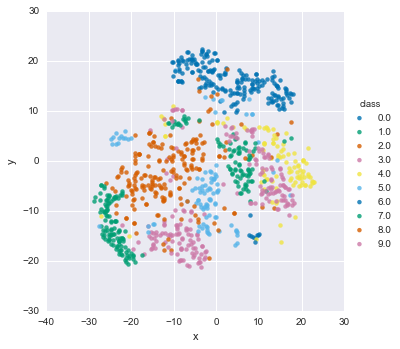

Generating stats for dataset 'Texture', layer 'layer_1'
p-value for dataset 'Texture', layer 'layer_1': 0.001000
Generating features for dataset 'Texture', layer 'layer_3'
t-SNE for dataset 'Texture', layer 'layer_3'


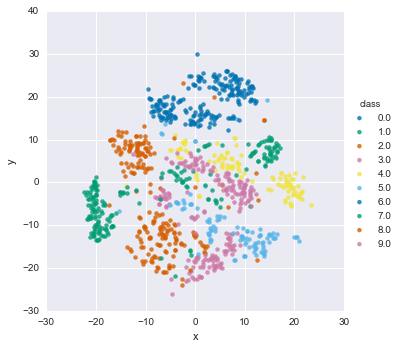

Generating stats for dataset 'Texture', layer 'layer_3'
p-value for dataset 'Texture', layer 'layer_3': 0.001000
Generating features for dataset 'Texture', layer 'layer_2'
t-SNE for dataset 'Texture', layer 'layer_2'


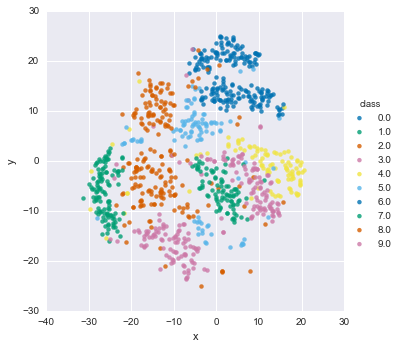

Generating stats for dataset 'Texture', layer 'layer_2'
p-value for dataset 'Texture', layer 'layer_2': 0.001000
Generating features for dataset 'Texture', layer 'layer_4'
t-SNE for dataset 'Texture', layer 'layer_4'


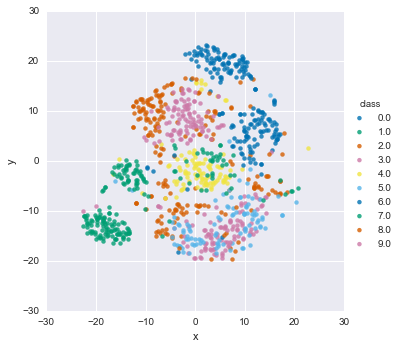

Generating stats for dataset 'Texture', layer 'layer_4'
p-value for dataset 'Texture', layer 'layer_4': 0.001000
Stats for dataset 'Texture'


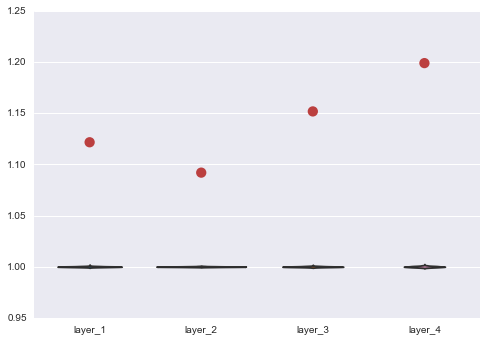



********************
********************




In [16]:
datasets = {'Texture' : {
                'data': dataset_gen("datasets/mnist/samples.csv", "datasets/mnist"),
                'labels': import_labels("datasets/mnist/samples.csv"),
                'plotTSNE': True
                }
           }
run(layers, datasets)